In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
import contextily as cx
from scipy import stats

pd.options.display.max_rows = 500
pd.options.display.max_columns = 200

import sys
sys.path.append('../src/')


## Load input data

### Marco geoestadístico

In [2]:
marco_geo_ent = gpd.read_file('../data/19_nuevoleon.gpkg', layer='19ent')
marco_geo_mun = gpd.read_file('../data/19_nuevoleon.gpkg', layer='19mun')
marco_geo_loc = gpd.read_file('../data/19_nuevoleon.gpkg', layer='19l')

### DENUE

Here we load the DENUE dataset. DENUE reports firms location and includes NAICS code and estimated number of employees in non regular intervals (bins). We keep NAICS code level 2 further aggregated into higher level classes that can be identified in the OD survey, which does not follow the NAICS classification.

We extract the employee counts intervals upper and lower bounds into new columns and verify firm locations lie within the reported municipality boundaries. Firms outside boundaries are assumed to be erroneous and dropped.

In [3]:
denue = pd.read_csv('../data/DENUE/denue_19_1119_csv/conjunto_de_datos/denue_inegi_19_.csv', encoding='ISO-8859-1', low_memory=False)
denue['NAICS_2'] = (denue.codigo_act/10000).astype(int)
denue['geometry'] = gpd.points_from_xy(denue.longitud, denue.latitud, crs="EPSG:4326")
denue = gpd.GeoDataFrame(denue).to_crs(marco_geo_ent.crs)#.loc[:, ['NAICS_2', 'per_ocu', 'geometry', 'latitud', 'longitud']]
denue['per_ocu_2'] = denue.per_ocu.replace('251 y más personas', '251 a 20000 personas')
denue[['lower', 'upper']] = denue.per_ocu_2.str.extract("^(\d+) a (\d+|inf) personas").astype(float)
denue['in_mun'] = False
denue['sector'] = denue.NAICS_2.map(
    {
        11: "Agricultura y ganadería", # 1 Agricultura, ganadería, aprovechamiento forestal, pesca y caza
        21: "Minería", # 2 Minería
        22: "Otro", # 3 Generación y distribución de electricidad, suministro de agua y gas
        23: "Construcción", # 4 Construcción
        31: "Industria manufacturera", # 5 Industrias manufactureras
        32: "Industria manufacturera", # 5 Industrias manufactureras
        33: "Industria manufacturera", # 5 Industrias manufactureras
        43: "Comercio", # 6 Comercio al por mayor
        46: "Comercio", # 7 Comercio al por menor
        48: "Transporte y comunicaciones", # 8 Transportes, correos y almacenamiento
        49: "Transporte y comunicaciones", # 8 Transportes, correos y almacenamiento
        51: "Otro", # 9 Información en medios masivos
        52: "Servicios", # 10 Servicios financieros y de seguros
        53: "Servicios", # 11 Servicios inmobiliarios y de alquiler de bienes
        54: "Servicios", # 12 Servicios profesionales, científicos y técnicos
        55: "Servicios", # 13 Corporativos
        56: "Servicios", # 14 Servicios de apoyo a los negocios y manejo de deshechos
        61: "Servicios", # 15 Servicios educativos
        62: "Servicios", # 16 Servicios de salud y de asistencia social
        71: "Servicios", # 17 Servicios de esparcimiento, culturales y deportivos
        72: "Servicios", # 18 Servicios de hospedaje y de preparación de alimentos y bebidas
        81: "Servicios", # 19 Otros servicios, excepto actividades gubernamentales
        93: "Gobierno", # 20 Actividades gubernamentales y de organismos internacionales
    }
)

In [4]:
# There are 12 points outside state boundaries
in_ent = denue.within(marco_geo_ent.unary_union)
(~in_ent).sum()

12

In [5]:
# There are 128 points outside their stated municipality
for mun in marco_geo_mun.CVE_MUN.values:
    denue_mun = denue.query(f'cve_mun == {int(mun)}')
    in_mun = denue_mun.within(marco_geo_mun.query('CVE_MUN == @mun').geometry.item())
    denue.loc[denue_mun.index, 'in_mun'] = in_mun
print(np.sum(~denue.in_mun.values))
# 116 of these are on municipality borders (as ploted on a map), the other 12 are the ones outside state borders
# We keep the 116 slighly displaced points and remove the 12 clearly misplaced ones

128


In [6]:
# Filter only relevan columns to avoid clutter
denue = denue[in_ent][[
    'codigo_act', 'per_ocu', 'cve_mun', 'municipio', 'cve_loc', 'localidad',
    'ageb', 'manzana', 'tipoUniEco',
    # 'latitud', 'longitud', 'fecha_alta',
    'NAICS_2', 'geometry', 'lower', 'upper', 'in_mun', 'sector'
]]

### TAZ

Here we load the traffic analysis zones geometries, we want to locate firms into this zones.

In [7]:
taz = gpd.read_file('../data/TAZ/Zonas.shp').to_crs(denue.crs).drop(columns='ESTADO')

### DENUE + TAZ

We join DENUE with TAZ to obtain each firm TAZ code dropping firmas not located in any TAZ.
One assumption we make is to take fix firmas as formal employment providers, so we drop non-fixed firms.

In [9]:
denue_taz = (
    denue.sjoin(taz[['ZONA', 'MACROZONA', 'geometry']], how='inner')[['ZONA', 'sector', 'tipoUniEco', 'lower', 'upper']]
    .reset_index(drop=True)
    .sort_values(['ZONA', 'sector', 'tipoUniEco', 'lower'])
    .query("tipoUniEco == 'Fijo'")
    .drop(columns='tipoUniEco')
    .copy()
)

In [10]:
denue_taz.head()

,ZONA,sector,lower,upper
25565,1,Comercio,0.0,5.0
25566,1,Comercio,0.0,5.0
25567,1,Comercio,0.0,5.0
25568,1,Comercio,0.0,5.0
25570,1,Comercio,0.0,5.0


In [11]:
denue_taz.shape

(157934, 4)

### ENOE

This ENOE databased is already preprocessed by the enoe.py script that cleans the database to train the informal job classifier.
It is the train set for the formal informa classifier, and thus we use to compare distributions.
The ENOE is representative at STATE level, so comparisons should be done at that level.

In [4]:
enoe = pd.read_csv('../data/ENOE/enoe_clean.csv', index_col=0)

### OD survey

Here we load the OD survey obtained as output from the formal/informal job classifier.

NOTE: This survey differs from the one used to obtain household, people, and trips tables for estimating choice models, since the latter was much more strictly preprocessed.

In [37]:
# TODO: load OD.

## Fitting a distribution to DENUE censored data

The first step of the job location pipeline is to obtain integer count jobs per TAZ per Sector for forma jobs.
Formal jobs are obtained from the DENUE fixed firm locations.
DENUE report job counts in intervals, from which we must estimate counts.
To do so, we fit a model to the binned dataset and use the model to generate expeted counts per bracket.
This model is fitted at the state level to minized sampling noise when fitting.

Firm size is known te be heavy tailed. Proposed models for heavy tail firm size distributions are:
- pareto or power law
- log normal
- exponential
- truncated pareto
- power law with exponential cutoff
- stretched exponential or Weibull

Not all this distributions are implemented in SciPy, so we leverage Matlab code to fit them.
This code uses continuous distributions. In reality, firm size is an integer variable, and a discrete distribution should be used.
Still, approximating firm size using continuous distributions and rounding to the nearest integer is a common procedure and greatly simplifies fitting, since there is no available code to fitted discrete binned data available.
Relevant references warn agains this and need to be further explored.
Discrete distributions that should be explored are:
- power law
- Yule
- Exponential
- Poisson

Ther error induced by using continuous distributions seem less relevant for binned data given the following considerations.
Consider a generative model that samples a real number from a continuous distribution, rounds it to the neasres integer, and finally assigns it to a bin. The binned data would be indistinguishable from a model that samples directly from a discrete distribution and then bins the data. Of course the adjusted parameters may differ between continuous and discrete version of the same distribution.
But if the modeling objective is to estimate the original data, then either model serves equally well.
In fact, one should use the one that results in the best fit.

Relevant references for this section are:
- Clauset, A., Shalizi, C. R., & Newman, M. E. (2009). Power-law distributions in empirical data. SIAM review, 51(4), 661-703.
- Virkar, Y., & Clauset, A. (2014). Power-law distributions in binned empirical data. The Annals of Applied Statistics, 8(1), 89.

Currently, a truncated pareto model seems to fit well, but hypothesis testing is pending.
An issue when fitting all models, is the unrealistic open ended last bin.
Without contraining the maximum allowed value of the last bin, tails of the distributions become inflated during MLE estimation.
By taking all the tail into account, when maximizing the likelihood, a high prbability mass in the tail is favored and the whole tail contributes to the likelihood.
On the other hand, is the last bin is constrained to a maximum, than contrinution of the tail to lieklihood is restricted and heavy tails are favored less during optimization.
The upper bound could potentially be estimated during the fitting process, may not during optimization.
I'm unsure how MLE would behave is the upper bound is allowed to change.
This upper bound is differet from the bound, but the mismihaviour of the truncated pareto hints that this would not be a good idea, as the upper bound of the distriution is inflated.

In [10]:
from distributions import binned_ll, ks_distance, fit_score_p

In [11]:
from scipy import stats
import matlab.engine

# here we load the Matlab engine to use matlab code in Python
mat_eng = matlab.engine.start_matlab()
mat_eng.cd(r'../plbinnedcode/', nargout=0)

In [17]:
# Data setup for fitting distributions
# We create the binned data structures needed for fitting in Scipy and Matlab
# We extend the bin intervals to cover the whole real line so that the
# continuous approximation is valid.
# Since minimum firm size is taken to be 1, the lowest bin interval is 1
# NOTE: Maybe we should try to find xmin in the interval (0 - 1],
# it may improve the fit of some functions.
# For xmin = 0 (almost 0) some distributions are simpler
# NOTE: 
# The highest interval is infinity, upper truncated distributions will restrict the domain.

# Adjusted continuous bins
denue_low, denue_up = (
    denue_taz.lower.replace(0, 1.5).values - 0.5,
    denue_taz.upper.values + 0.5
)

# censored data structure for scipy
# denue_censored = stats.CensoredData().interval_censored(denue_low, denue_up)

# The empirical CDF, which has heavy tail behaivoir in log log space
denue_cdf = (
    # pd.Series(denue_up).value_counts().sort_index().cumsum()/len(denue_taz)
    pd.concat(
        [
            pd.Series([0], index=[1]),
            pd.Series(denue_up).value_counts().sort_index()
        ]
    ).rename('count').cumsum()/len(denue_taz)

).to_frame().reset_index()
denue_sf = denue_cdf.copy()
denue_sf['count'] = 1 - denue_sf['count']

# The binned data array for Matlab
# boundary values and counts
boundaries = np.ones(len(denue_cdf))
boundaries = denue_cdf['index'].values
h = pd.Series(denue_up).value_counts().sort_index().values

The simples fit to a power law is a line fit on log-log scale. This estiamtor have bad properties as discussed in the relevant literature, but serves as a baseline and as starting point for likelihood based optimization.
Scipy and Matlab implementations of the distributions are equivalent but differ in their parametrization.
We discuss differences for each distribution when fitting them.

Scipy uses a custom paramerization among all its distributions, which always include loc and scale parameters, so that $x \rightarrow (x-l)/s$. Loc and scale sometimes match standard forms of the distributions, but often not, and are only general parametrs of location and scale. Other parameres are called shape parameters. Scipy docs provide f(x), with domain [x1, x2]. The fully parametrized density is

$$
p(x) = \frac{1}{s}f(\frac{x-l}{s}); \quad \left[s x_1 + l, s x_2 + l\right]
$$

### Linear fit and power law truncated from below

A simple OLS fit is done for the log(x), log(CDF(x)), the slope is the approximated exponent of the power law.

For the power law or Pareto distribution:
In Matlab, the power law density and survival function S is 

$$
p(x) = \frac{\alpha-1}{x_{min}} \left( \frac{x}{x_{min}} \right)^{-\alpha}
$$

$$
S(x) = \left( \frac{x}{x_{min}} \right)^{1 - \alpha}
$$

subjet to 
$$ x_{min} \leq x \leq \infty; \quad \alpha > 1$$

In Scipy, with $loc=0$ and $scale=s$, we have

$$
p(x) = \frac{1}{s}\frac{b}{(x/s)^{b+1}} = \frac{b}{s}\left(\frac{x}{s}\right)^{-b-1}
$$

subjet to 
$$ s \leq x \leq \infty; \quad b > 0$$

which means

$$
\alpha = b + 1; \quad x_{min} = s
$$



In [15]:
# A OLS linear regression on log log axes on the CDF.
# This just provides an initial guess of the exponent.
# This is b parameter in scipy, alpha = b + 1
lr = stats.linregress(np.log(denue_sf['index'].values[:-1]), np.log(denue_sf['count'].values[:-1]))
def res_line(x):
    return np.exp(lr.slope*np.log(x) + lr.intercept)
b0 = -lr.slope
alpha0 = b0 + 1
print(f"alpha0 = {alpha0}")

alpha0 = 1.909416489883184


For our application, this exponent is problematic, since the mean of the pareto distriution diverges for $\alpha \leq 2$. This makes imposible to find an expected number of jobs for the upper bracket, which was the motivation of this whole enterprise in the first place. We need to estimate a distribution with finite moments. We still fit the power law to compare the fit with alternative distributions.

The pareto distribution truncated form below is implemented in both scipy and matlab, as discussed above.
Scale sets $x_{min}$ in Scipy.

The power law is not a good fit in the whole domain, the p-value is 0 as the model must be rejected. This is similar for other alternative distributions, namely, lognormal and the truncated pareto distribution.
If we estimate bmin as well, the algorithm chooses 100.5 as bmin, which leaves just two bins in the rail.
This is, a powerlaw fits the last two bins almost perfectly, which makes sense since the sample size is not really small.
The question is, is it useful to have a power law just in last part of the distribution?
Namely, for counts above 100?

In [18]:
# We need a wrapper function that takes the data to fit and returns a scipy fitted dist
def fit_pareto(mat_eng, boundaries, h, bmax=None, verbose=False):
    # Fit a powelaw using matlab
    if bmax is None:
        # Bmin is unrestricted
        alpha, bmin, L = mat_eng.bplfit(h.astype(float), boundaries, nargout=3)
    else:
        # bmin must be estimated below provided value
        alpha, bmin, L = mat_eng.bplfit(h.astype(float), boundaries, 'limit', bmax, nargout=3)
    if verbose:
        print(alpha, bmin, L)
    dist = stats.pareto(alpha - 1, loc=0, scale=bmin)
    return dist

In [19]:
# an unrstricted search chooses the last two bins
pareto_fit = fit_pareto(mat_eng, boundaries, h, bmax=None, verbose=True)

1.9337890625000023 5.5 -47508.92206387673


In [29]:
# An unrestricted search
p, d, D = mat_eng.bplpva(h.astype(float), boundaries, 5.5, 'silent', 'reps', 1000.0, nargout=3)
d = np.array(d)
p

0.352

So the powerlaw for bmin=5.5 but is a valid model.

### Lognormal distribution fit

Scipy is missing most truncated distributions, to avoid reimplementing the methods we use the matlab implementation.

To obtains the truncated dsitribution, we can normalize the scipy distribution by 1 / (F(xmax) - F(xmin)).

The standard lognormal is given by

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}}\frac{1}{x}\exp\left( -\frac{\left( \ln{x} - \mu \right)^2}{2\sigma^2}  \right)
$$

$$
S(x) = \frac{1}{2}\left( 1 + erf\left( \frac{\ln{x} - \mu}{\sqrt{2}\sigma} \right)\right)
$$

subjet to 
$$ 0 < x < \infty; \quad \sigma > 0$$

So that by scaling we obtain the Matlab parametrization for the lower truncated lognormal.

$$
p_t(x) = \frac{p(x)}{F(\infty) - F(x_{min})} 
= \frac{2}{erfc\left( \frac{\ln{x} - \mu}{\sqrt{2}\sigma} \right)} p(x)
= \frac{1}{erfc\left( \frac{\ln{x} - \mu}{\sqrt{2}\sigma} \right)}
\sqrt{\frac{2}{\pi \sigma^2}}\frac{1}{x}\exp\left( -\frac{\left( \ln{x} - \mu \right)^2}{2\sigma^2}  \right)
$$

subjet to 
$$ x_{min} < x < \infty; \quad \sigma > 0$$

In Scipy, $loc=0$, $scale=e^\mu$, and $s=\sigma$, we have

$$
p(x) = 
$$

subjet to 
$$ s \leq x \leq \infty; \quad b > 0$$

which means

$$
\alpha = b + 1; \quad x_{min} = s
$$


In [30]:
# We need a wrapper function that takes the data to fit and returns a scipy fitted dist
def fit_lognorm(mat_eng, boundaries, h, bmin, verbose=False):
    # Fit a powelaw using matlab, bmin must be chosen
    # comparison to other models must be made when fitted to the same bins.
    mu, sigma, L = mat_eng.blgnormfit(
        h.astype(float), boundaries, [], [], 'bmin', bmin, nargout=3
    )
    if verbose:
        print(mu, sigma, L)
    dist = stats.lognorm(s=sigma, loc=0, scale=np.exp(mu))
    return dist

In [31]:
lognorm_fit = fit_lognorm(mat_eng, boundaries, h, bmin=5.5, verbose=True)

-52.9 7.800000000000002 -47510.47180713275


Looking at the likelihood, models seem equivalent.
The main reason to choose lognormal is that the moments are finite.

In [32]:
for bmin in [5.5]:
    lognorm_fit = fit_lognorm(mat_eng, boundaries, h, bmin=bmin, verbose=False)
    p, d, D = fit_score_p(boundaries, h, lognorm_fit, fit_lognorm, mat_eng,
               bmin=bmin, reps=1000, 
               inv_samp=True)
    print(bmin, p)

5.5 0.003


In [27]:
# The negative log likelihood needs the renormalization constant
# TODO: contrain domain
C_ln = lognorm_fit.cdf(np.inf) - lognorm_fit.cdf(5.5)
binned_ll(boundaries, h, lognorm_fit, C_ln)

110198.96308981767

### Exponential distribution

In [33]:
l, L = mat_eng.bexpnfit(h.astype(float), boundaries, 'bmin', 5.5, nargout=2)
l, L

(0.041257812500000046, 62089.84867256257)

### Power law with cutoff

This one is not available in Scipy so we cannot generate random variates until we implement the distribution.

In [34]:
a, l, L = mat_eng.bplcutfit(h.astype(float), boundaries, 'bmin', 5.5, nargout=3)
a, l, L

Power law with cut off distribution, parameter calculation
    Copyright 2012 Yogesh Virkar


(1.9243369462456839, 4.940022241470976e-05, 47497.658366214375)

### Stretched exponential or Weibull

In [35]:
l, b, L = mat_eng.bstexpfit(h.astype(float), boundaries, 'bmin', 5.5, nargout=3)
l, b, L

(205.18208431331865, 0.00449528061124127, 47508.63532411172)

Ok, so all models seem equally valid, given that only two bins are fitted, all fits seem good enough.
From the literature, we most likely expect either a power law or a lognormal.
So we use the log normal to sample from the upper two bins.

### Truncated pareto distribution

This is fitted in scipy.


In [18]:
N = h.sum()

In [19]:
boundaries[-1]=5000

In [20]:
def build_censored(h, boundaries, bmin):
    bmin_idx = np.where(boundaries==bmin)[0][0]
    h = h[bmin_idx:]
    boundaries = boundaries[bmin_idx:]
    
    N = h.sum()
    hh = h.cumsum()
    
    low = np.zeros(N)
    high = np.zeros(N)
    
    low[:hh[0]] = boundaries[0]
    high[:hh[0]] = boundaries[1]
    for i in range(len(hh)-1):
        low[hh[i]:hh[i+1]] = boundaries[i+1]
        high[hh[i]:hh[i+1]] = boundaries[i+2]
    censored = stats.CensoredData().interval_censored(low, high)
    return censored

In [380]:
bmin=1
denue_censored = build_censored(h, boundaries, bmin=bmin)
p1, p2, p3, p4 = stats.truncpareto.fit(denue_censored, 1, 200000 ,floc=0, fscale=bmin)
truncpareto = stats.truncpareto(p1, p2, p3, p4)
p1, p2, p3, p4, p2*p4

(0.8755383195329098, 2269.952186164651, 0, 1, 2269.952186164651)

In [23]:
bmin=5.5
denue_censored = build_censored(h, boundaries, bmin=bmin)
p1, p2, p3, p4 = stats.truncpareto.fit(denue_censored, 1, 10000 ,floc=0, fscale=bmin)
truncpareto = stats.truncpareto(p1, p2, p3, p4)
p1, p2, p3, p4, p2*p4

(0.9256662550653376, 909.0908675035765, 0, 5.5, 4999.999771269671)

In [24]:
Nbmin = h[1:].sum()
truncpareto.mean()*Nbmin + 121841*3 

1998308.6844514937

In [30]:
truncpareto.rvs(size=N).max()

4987.99468305726

In [31]:
binned_ll(boundaries[1:], h[1:], truncpareto)

NameError: name 'binned_ll' is not defined

In [378]:
truncpareto.expect(lambda x: x, lb=250.5, ub=5000, conditional=True)*1000

829398.2897422237

In [141]:
bs_sample = truncpareto.rvs(size=(Nbmin))
bs_h = np.histogram(bs_sample, bins=boundaries)[0]
bs_censored = build_censored(bs_h, boundaries, 5.5)
p1, p2, p3, p4 = stats.truncpareto.fit(bs_censored, 1, 20000 ,floc=0, fscale=5.5)
truncpareto_bs = stats.truncpareto(p1, p2, p3, p4)
p1, p2, p3, p4, p2*p4

(0.9307035684204885, 3138.2399699056978, 0, 5.5, 17260.31983448134)

In [275]:
denue_sf

,index,count
0,1.0,1.000000
1,5.5,0.228532
2,10.5,0.124799
3,30.5,0.046165
4,50.5,0.028322
5,100.5,0.015639
6,250.5,0.006794
7,20000.5,0.000000


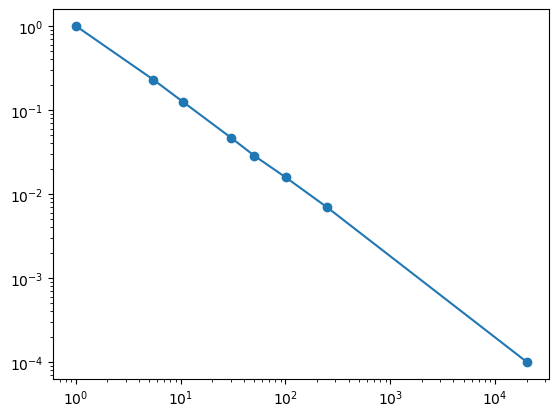

In [280]:
plt.loglog(denue_sf['index'], denue_sf['count']+.0001, 'o-')

### Calculating the likelihood ratio

In [594]:
alpha, bmin, L = mat_eng.bplfit(h.astype(float), boundaries, nargout=3)
p1 = mat_eng.getPDF(boundaries, bmin, 'pl', alpha)
p1 = np.array(p1)
alpha, bmin, L

(1.912890625000002, 100.5, -1690.7619696722359)

In [596]:
mu, sigma, L = mat_eng.blgnormfit(
        h.astype(float), boundaries, [], [], 'bmin', bmin, nargout=3
    )
p2 = mat_eng.getPDF(boundaries, bmin, 'lgnorm', mu, sigma)
p2 = np.array(p2)

In [601]:
# This can't be done with just two bins.
#mat_eng.blrtest(p1, p2, h, boundaries, bmin, 0, nargout=2)

### Finding expected counts and standard deviations per bin

In [13]:
formal_jobs = denue_taz.groupby(['ZONA', 'sector', 'lower', 'upper']).size().rename('h').reset_index()

In [14]:
formal_jobs = formal_jobs.assign(
    lower=formal_jobs.lower.astype(int),
    upper=formal_jobs.upper.astype(int)
)

In [432]:
la = np.sort(formal_jobs.lower.unique())[1:]
ua = np.sort(formal_jobs.upper.unique())[1:]
edict = {}
stddict = {}
for l, u in zip(la, ua):
    e = truncpareto.expect(lambda x: x, lb=l-0.5, ub=u+0.5, conditional=True)
    edict[(l,u)] = e
    var = truncpareto.expect(lambda x: (x-e)**2, lb=l-0.5, ub=u+0.5, conditional=True)
    stddict[(l,u)] = np.sqrt(var)

In [15]:
def get_expected_std(r, bmin=5.5):
    l = r.lower
    if l < 1:
        l = 1
    u = r.upper
    h = r.h
    if l < bmin:
        e = h*(l+u)/2
        std = np.sqrt(h*((u - l + 1)**2 - 1)/12)
        
        return pd.Series([e, std, h*l, h*u], index=['E', 'STD', 'min', 'max'])
    else:
        e = edict[(l,u)]
        std = stddict[(l,u)]
        return pd.Series([h*e, np.sqrt(h)*std, h*l, h*u], index=['E', 'STD', 'min', 'max'])

In [449]:
formal_jobs[['E', 'STD', 'min', 'max']] = formal_jobs.apply(get_expected_std, axis=1, result_type='expand')
formal_jobs['VAR'] = formal_jobs.STD**2

In [443]:
formal_jobs.to_csv('../output/denue_by_taz_estimated.csv', index=False)

In [450]:
formal_jobs.head()

,ZONA,sector,lower,upper,h,E,STD,min,max,VAR
0,1,Comercio,0,5,1601,4803.000000,56.586217,1601.0,8005.0,3202.000000
1,1,Comercio,6,10,229,1714.704645,21.297945,1374.0,2290.0,453.602477
2,1,Comercio,11,30,74,1272.329890,46.394458,814.0,2220.0,2152.445698
3,1,Comercio,31,50,8,311.154213,16.080842,248.0,400.0,258.593477
4,1,Comercio,51,100,14,980.811338,52.485221,714.0,1400.0,2754.698454


In [452]:
formal_jobs_agg = formal_jobs.groupby(['ZONA', 'sector'])[['h', 'E', 'min', 'max', 'VAR']].sum().reset_index()

In [454]:
formal_jobs_agg['STD'] = np.sqrt(formal_jobs.VAR)

In [456]:
formal_jobs_agg.to_csv('../output/denue_by_taz_estimated.csv', index=False)

In [472]:
formal_jobs_agg.groupby('sector').E.sum()/formal_jobs_agg.groupby('sector').E.sum().sum()*100

sector
Agricultura y ganadería         0.015341
Comercio                       24.829872
Construcción                    2.755845
Gobierno                        3.531437
Industria manufacturera        22.481255
Minería                         0.027626
Otro                            0.909130
Servicios                      41.053431
Transporte y comunicaciones     4.396062
Name: E, dtype: float64

In [460]:
# Comprar con la dsitribución de la ENOE

In [473]:
enoe.groupby('sector').size()/len(enoe)*100

sector
Agricultura y ganadería         2.707830
Comercio                       17.954467
Construcción                    7.916523
Gobierno                        2.880304
Industria manufacturera        23.094170
Minería                         0.103484
Otro                            1.535012
Servicios                      37.219731
Transporte y comunicaciones     6.588479
dtype: float64

In [477]:
enoe.query("informal==0").groupby('sector').size()/len(enoe.query("informal==0"))*100

sector
Agricultura y ganadería         0.939486
Comercio                       15.473888
Construcción                    4.752694
Gobierno                        3.619784
Industria manufacturera        32.467532
Minería                         0.165792
Otro                            2.017132
Servicios                      33.683338
Transporte y comunicaciones     6.880354
dtype: float64

In [476]:
enoe

,SCIAN,MUN,genero,ocupacion,edad_num,edad_cat,sector,escolaridad,informal,municipio
0,19,6,F,independiente,28,"[25, 50)",Servicios,Primaria o Secundaria,1,apodaca
1,4,6,H,independiente,32,"[25, 50)",Construcción,Primaria o Secundaria,1,apodaca
2,5,6,F,trabajador,25,"[25, 50)",Industria manufacturera,Carrera técnica o preparatoria,0,apodaca
3,5,6,F,trabajador,33,"[25, 50)",Industria manufacturera,Carrera técnica o preparatoria,1,apodaca
4,5,6,F,trabajador,52,"[50, 60)",Industria manufacturera,Carrera técnica o preparatoria,0,apodaca
...,...,...,...,...,...,...,...,...,...,...
5793,1,9,H,trabajador,64,"[60, 65)",Agricultura y ganadería,Primaria o Secundaria,1,cadereyta
5794,19,9,F,trabajador,56,"[50, 60)",Servicios,Primaria o Secundaria,1,cadereyta
5795,19,9,H,trabajador,56,"[50, 60)",Servicios,Primaria o Secundaria,0,cadereyta
5796,4,9,H,trabajador,50,"[50, 60)",Construcción,Primaria o Secundaria,1,cadereyta
